# Black Lives Matter: Topic Modeling

This analysis was inspired by the [_Topic Modeling with Gensim (Python)_ post](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/), which can be found on the Machine Learning Plus blog.

## Import libraries

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/opardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import random

In [3]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [4]:
# spacy for lemmatization
import spacy

In [5]:
# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [7]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [8]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

## Import data

In [9]:
from google.cloud import bigquery
from google.oauth2 import service_account

In [46]:
#Load GOOGLE_APPLICATION_CREDENTIALS = ... .json

In [11]:
%load_ext google.cloud.bigquery

In [12]:
%%bigquery df
SELECT
    DISTINCT full_text_cleaned AS full_text
FROM tweets.all_valid_tweets
WHERE ferguson_ht + michael_brown = 2
    AND is_retweet = FALSE

In [13]:
data = list(df['full_text'])

## Pre-processing tweets

### Decompose into bag of words

Let's take a tweet in our data:

In [14]:
tweet = 'News: Man who shot video of Eric Garner in apparent choke hold arrested on firearms charges.'
print(tweet)

News: Man who shot video of Eric Garner in apparent choke hold arrested on firearms charges.


Now we will decompose this tweet into an array of words, where the order doesn't matter.

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
def unique_list_of_lists(lol):
    unique_lol = set(map(tuple, lol))
    unique_lol = list(map(list, unique_lol))
    return(unique_lol)
    
data_words = list(sent_to_words(data))

#Example
tweet_words = list(sent_to_words([tweet]))
print(tweet_words[0])

['news', 'man', 'who', 'shot', 'video', 'of', 'eric', 'garner', 'in', 'apparent', 'choke', 'hold', 'arrested', 'on', 'firearms', 'charges']


### Stop words

There are commonly used words (such as “the”, “a”, “an”, “in”) which appear that often, that are useless to understand the context we are analyzing. Moreover, since they are common, they make the NLP techniques to spend more time processing, without adding any value. Therefore, we will remove them from every tweet.

In [16]:
stop_words.extend(['ferguson', 'michael', 'mike', 'brown', 'michaelbrown', 'mikebrown', 'url'])
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Remove Stop Words
data_words_nostops = unique_list_of_lists(remove_stopwords(data_words))

#Example
tweet_words_nostops = remove_stopwords(tweet_words)
print(tweet_words_nostops[0])

['news', 'man', 'shot', 'video', 'eric', 'garner', 'apparent', 'choke', 'hold', 'arrested', 'firearms', 'charges']


### Bigrams and Trigrams

There are concepts like _Eric Garner_ or _New York_ which make more sense to be analyzed as a single word, than being split into two. To achieve that we will use the concept of bigrams and trigrams.

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=20)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [18]:
def make_bigrams(texts):
    return [remove_underscore(bigram_mod[doc]) for doc in texts]

def make_trigrams(texts):
    return [remove_underscore(trigram_mod[bigram_mod[doc]]) for doc in texts]

def remove_underscore(doc):
    return([re.sub("_", "", word) for word in doc])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Example
tweet_words_bigrams = make_bigrams(tweet_words_nostops)
print(tweet_words_bigrams[0])

['news', 'man', 'shot', 'video', 'ericgarner', 'apparent', 'choke', 'hold', 'arrested', 'firearms', 'charges']


### Lemmatization

Finally, we would like to tackle one last challenge: The fact that a word used as a singular or plural should be considered the same. Similar case when you conjugate a verb or you use verbs and adjectives with the same origin. 

These kinds of problems are solved by _Lemmatization_ , a technique that transforms any single word to its root.

In [20]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Example
tweet_lemmatized = lemmatization(tweet_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(tweet_lemmatized[0])

['news', 'man', 'shoot', 'video', 'ericgarner', 'apparent', 'choke', 'hold', 'arrest', 'firearm', 'charge']


## Modeling topics

### Build corpora

Once we have the pre-processed tweets we want to model, we need to make them comparable on a mathematical way. To achieve that, we will create as many dimensions as we have unique words in the set of tweets. Then, we will assign to each word the number of times it was mentioned in the tweet (and zero if it didn't appear).

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Example
print(id2word.doc2bow(tweet_lemmatized[0]))

[(37, 1), (69, 1), (81, 1), (98, 1), (104, 1), (166, 1), (179, 1), (216, 1), (826, 1), (5231, 1), (7212, 1)]


In [22]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in [id2word.doc2bow(tweet) for tweet in tweet_lemmatized]]

[[('ericgarner', 1),
  ('arrest', 1),
  ('news', 1),
  ('man', 1),
  ('video', 1),
  ('shoot', 1),
  ('hold', 1),
  ('firearm', 1),
  ('charge', 1),
  ('choke', 1),
  ('apparent', 1)]]

### LDA Mallet Model

To model the different topics, we are going to use the Latent Dirichlet Allocation (LDA) technique. Specifically, we are going to use the Mallet implementation, which is a Java-based package for statistical NLP.

In [23]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(
    mallet_path,
    corpus=corpus,
    num_topics=10,
    id2word=id2word,
    alpha=1,
    optimize_interval=50,
    workers=7,
    random_seed=2019
)

This will give us 10 different topics (a fixed parameter we used). Now, we are going to explore the 10 words most representative of each of these topics. 

In [24]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('police', 0.03708127026780457),
   ('robbery', 0.02091678899919551),
   ('video', 0.020012772345384126),
   ('cop', 0.01854478199928674),
   ('officer', 0.01846184469159762),
   ('shoot', 0.017591002960861885),
   ('release', 0.013966642614847436),
   ('darrenwilson', 0.013037744768729317),
   ('kill', 0.011768803961085815),
   ('murder', 0.010939430884194638)]),
 (1,
  [('rt', 0.04661867515747214),
   ('racism', 0.03793175053644355),
   ('black', 0.03668581712466256),
   ('white', 0.03253270575205925),
   ('handsupwalkoutcloser', 0.02332664220945525),
   ('tshirt', 0.020903993908769986),
   ('asianfu', 0.020454073510071294),
   ('pandadaomey', 0.020454073510071294),
   ('column', 0.019761888281304076),
   ('share', 0.014397452758358137)]),
 (2,
  [('pd', 0.021711116548405514),
   ('solidarity', 0.021450126417094855),
   ('dontshoot', 0.018628170622298344),
   ('closerlook', 0.018399804257401516),
   ('nmos', 0.018024630943642445),
   ('justice', 0.017714705162711036),
   ('pr

Finally, we will obtain the coherence score, a metric that will indicate how good the model fit is.

In [25]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.3337680502778116


### Choosing the number of topics

As we mentioned before, the number of topics was fixed to 10. However, we would like to optimize that hyper-parameter as well to improve the model performance. To achieve that we will use the Coherence Score, trying different values, and analyzing which is the one with the best performance.

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(
            mallet_path,
            corpus=corpus,
            num_topics=num_topics,
            id2word=id2word,
            alpha=1,
            optimize_interval=50,
            workers=7,
            random_seed=2019
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=22, step=2)

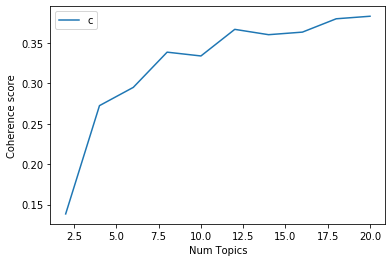

In [28]:
# Show graph
limit=22; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.1385
Num Topics = 4  has Coherence Value of 0.2724
Num Topics = 6  has Coherence Value of 0.2949
Num Topics = 8  has Coherence Value of 0.3385
Num Topics = 10  has Coherence Value of 0.3338
Num Topics = 12  has Coherence Value of 0.3667
Num Topics = 14  has Coherence Value of 0.3601
Num Topics = 16  has Coherence Value of 0.3632
Num Topics = 18  has Coherence Value of 0.3797
Num Topics = 20  has Coherence Value of 0.3829


### Working with the optimal model

The model we liked the most was the one with 8 topics. Although the 4-theme model has the best performance, the 8-theme balances the diversity of topics with acceptable performance.

In [30]:
optimal_model = model_list[5]

In [31]:
# Print the topics
pprint(optimal_model.show_topics(formatted=False, num_topics=20))

[(0,
  [('protest', 0.022667736709014098),
   ('dontshoot', 0.021683499644160446),
   ('solidarity', 0.02079011523144713),
   ('justice', 0.019260762253751458),
   ('support', 0.01916990960161112),
   ('rally', 0.018473372601868536),
   ('nmos', 0.01733771445011432),
   ('march', 0.016944019624172864),
   ('stand', 0.015278387668266682),
   ('hand', 0.011386865734922246)]),
 (1,
  [('live', 0.041914604864808434),
   ('watch', 0.029752583777012214),
   ('cnn', 0.02166196889028082),
   ('funeral', 0.018651912168980756),
   ('livestream', 0.01511988029369802),
   ('speak', 0.013501757316351741),
   ('mo', 0.010439503079653408),
   ('msnbc', 0.008908375961304242),
   ('discuss', 0.008838779274106553),
   ('talk', 0.008334203291923305)]),
 (2,
  [('death', 0.012589294958070193),
   ('story', 0.010166683921731028),
   ('read', 0.010073506574179521),
   ('tweet', 0.0083031369707009),
   ('news', 0.008272077854850398),
   ('medium', 0.006967594989129309),
   ('happen', 0.006429236981053939),
 

## Exploring the results

### Dominant topic in each sentence

In [32]:
def format_topics_sentences(ldamodel, corpus, texts, words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    bow = pd.Series(words)
    sent_topics_df = pd.concat([sent_topics_df, contents, bow], axis=1)
    return(sent_topics_df)

def create_corpus(data):
    data_words = list(sent_to_words(data))
    data_words_nostops = remove_stopwords(data_words)
    data_words_bigrams = make_bigrams(data_words_nostops)
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    corpus = [id2word.doc2bow(text) for text in data_lemmatized]
    return(corpus)


corpus_ = create_corpus(data)
df_topic_sents_keywords = format_topics_sentences(optimal_model, corpus_, data, data_words)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Words']

In [33]:
# Show
pd.set_option('display.max_colwidth', -1)
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Words
0,0,6.0,0.7347,"black, people, white, cop, kill, police, man, murder, thug, make",just wait cops will start reporting how much weed mikebrown smoked and his trash rap style as if he deserved to die ferguson,"[just, wait, cops, will, start, reporting, how, much, weed, mikebrown, smoked, and, his, trash, rap, style, as, if, he, deserved, to, die, ferguson]"
1,1,3.0,0.8517,"shoot, shot, head, time, witness, autopsy, shooting, officer, eyewitness, cop",witness conversation captured unknowingly after michaelbrown shooting $URL$ ferguson fergusonshooting,"[witness, conversation, captured, unknowingly, after, michaelbrown, shooting, url, ferguson]"
2,2,4.0,0.8410,"police, officer, shoot, release, darrenwilson, kill, case, shooting, death, anonymous",waposean no incident report no accountability this is a travesty of justice! ferguson mike brown $URL$,"[waposean, no, incident, report, no, accountability, this, is, travesty, of, justice, ferguson, mike, brown, url]"
3,3,10.0,0.8711,"video, robbery, pd, police, release, closerlook, msnbcallstar, store, suspect, officer",the robbery is irrelevant mikebrown died for it he paid his dues and then some! where is police video of the murder? ferguson fergusonqs,"[the, robbery, is, irrelevant, mikebrown, died, for, it, he, paid, his, dues, and, then, some, where, is, police, video, of, the, murder, ferguson, fergusonqs]"
4,4,6.0,0.7197,"black, people, white, cop, kill, police, man, murder, thug, make",the hateful things said by whites since mikebrowns shooting have made me realize how scared many are ive known this 1 2 ferguson,"[the, hateful, things, said, by, whites, since, mikebrowns, shooting, have, made, me, realize, how, scared, many, are, ive, known, this, ferguson]"
5,5,2.0,0.4762,"death, story, read, tweet, news, medium, happen, follow, brown, twitter",not coincidence every student arrested in the ferguson school district in most recent year was black mikebrown $URL$,"[not, coincidence, every, student, arrested, in, the, ferguson, school, district, in, most, recent, year, was, black, mikebrown, url]"
6,6,8.0,0.8441,"rt, racism, black, white, handsupwalkoutcloser, tshirt, pandadaomey, asianfu, share, column",rt and share!! let the city of atlanta know!! youngjeezy ludacris youngthug mikebrown ferguson $URL$,"[rt, and, share, let, the, city, of, atlanta, know, youngjeezy, ludacris, youngthug, mikebrown, ferguson, url]"
7,7,4.0,0.8306,"police, officer, shoot, release, darrenwilson, kill, case, shooting, death, anonymous",hundreds rally in ferguson to demand justice for michaelbrowns death $URL$ $URL$,"[hundreds, rally, in, ferguson, to, demand, justice, for, michaelbrowns, death, url, url]"
8,8,6.0,0.4111,"black, people, white, cop, kill, police, man, murder, thug, make",i dont understand how the riots goin on in ferguson are bringing any justice to the michael brown shooting,"[dont, understand, how, the, riots, goin, on, in, ferguson, are, bringing, any, justice, to, the, michael, brown, shooting]"
9,9,2.0,0.4805,"death, story, read, tweet, news, medium, happen, follow, brown, twitter",things i saw today in ferguson $URL$ michaelbrown stlpublicradio,"[things, saw, today, in, ferguson, url, michaelbrown, stlpublicradio]"


### Most representative tweets

In [34]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(10)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", "Words"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Words
0,0.0,0.9587,"protest, dontshoot, solidarity, justice, support, rally, nmos, march, stand, hand",thurs aug 14 nmos14 in dc malcolm x park meridan hill nw 7pm mikebrown ferguson dmv dc md va nmos14dc $URL$,"[thurs, aug, nmos, in, dc, malcolm, park, meridan, hill, nw, pm, mikebrown, ferguson, dmv, dc, md, va, nmos, dc, url]"
1,0.0,0.9554,"protest, dontshoot, solidarity, justice, support, rally, nmos, march, stand, hand",como if you want to donate bottled water food toiletries baby supplies ill take em to ferguson tmrw moleg mikebrown dontshoot,"[como, if, you, want, to, donate, bottled, water, food, toiletries, baby, supplies, ill, take, em, to, ferguson, tmrw, moleg, mikebrown, dontshoot]"
2,0.0,0.9554,"protest, dontshoot, solidarity, justice, support, rally, nmos, march, stand, hand",&gt;6pm&lt; mpls solidarity rally 4 mike brown and victims of police brutality ferguson thurs 8 28 6pm hnnpn cty gvmt ctr $URL$,"[gt, pm, lt, mpls, solidarity, rally, mike, brown, and, victims, of, police, brutality, ferguson, thurs, pm, hnnpn, cty, gvmt, ctr, url]"
3,0.0,0.9554,"protest, dontshoot, solidarity, justice, support, rally, nmos, march, stand, hand",mt lapeoplesmedia demonstrations for justice for ezellford! 3pm friday 65th and broadway and 3pm sunday at lapd hq michaelbrown ferguson,"[mt, lapeoplesmedia, demonstrations, for, justice, for, ezellford, pm, friday, th, and, broadway, and, pm, sunday, at, lapd, hq, michaelbrown, ferguson]"
4,0.0,0.9554,"protest, dontshoot, solidarity, justice, support, rally, nmos, march, stand, hand",mt “rkbtwo dc natl moment of silence honoring mikebrown malcolm x prk tnt 7pm ferguson sunniandthecity angela_rye” dreamdefenders,"[mt, rkbtwo, dc, natl, moment, of, silence, honoring, mikebrown, malcolm, prk, tnt, pm, ferguson, sunniandthecity, angela_rye, dreamdefenders]"
5,0.0,0.9554,"protest, dontshoot, solidarity, justice, support, rally, nmos, march, stand, hand",today toronto will be standing up for mikebrown 12pm yonge n dundas square spread the word and hashtags handsupto towithfg ferguson,"[today, toronto, will, be, standing, up, for, mikebrown, pm, yonge, dundas, square, spread, the, word, and, hashtags, handsupto, towithfg, ferguson]"
6,0.0,0.9539,"protest, dontshoot, solidarity, justice, support, rally, nmos, march, stand, hand",national day of rage losangeles 14aug14 4pm leimert plaza park 4395 leimert blvd l a ca 90008 ferguson opferguson mikebrown occupy,"[national, day, of, rage, losangeles, aug, pm, leimert, plaza, park, leimert, blvd, ca, ferguson, opferguson, mikebrown, occupy]"
7,0.0,0.9516,"protest, dontshoot, solidarity, justice, support, rally, nmos, march, stand, hand",houston solidarity for mikebrown and ferguson demonstration today led by nbufs kofitaharka at noon in 5th ward lockwood lyons,"[houston, solidarity, for, mikebrown, and, ferguson, demonstration, today, led, by, nbufs, kofitaharka, at, noon, in, th, ward, lockwood, lyons]"
8,0.0,0.9516,"protest, dontshoot, solidarity, justice, support, rally, nmos, march, stand, hand",&gt; wear red ribbons or arm bands to show your support &gt; 6p daley center chicago protest in honor of mikebrown and ferguson,"[gt, wear, red, ribbons, or, arm, bands, to, show, your, support, gt, daley, center, chicago, protest, in, honor, of, mikebrown, and, ferguson]"
9,0.0,0.9516,"protest, dontshoot, solidarity, justice, support, rally, nmos, march, stand, hand",1 2 naples residents will gather at pier tonight for vigil for mikebrown ferguson vigil co sponsored by collier naacp and occupy naples,"[naples, residents, will, gather, at, pier, tonight, for, vigil, for, mikebrown, ferguson, vigil, co, sponsored, by, collier, naacp, and, occupy, naples]"


### Topic Distribution

In [35]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts().sort_index()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4).sort_index()

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()\
    .sort_values('Dominant_Topic').reset_index(drop=True)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"protest, dontshoot, solidarity, justice, support, rally, nmos, march, stand, hand",12162,0.0746
1.0,1.0,"live, watch, cnn, funeral, livestream, speak, mo, msnbc, discuss, talk",10077,0.0618
2.0,2.0,"death, story, read, tweet, news, medium, happen, follow, brown, twitter",16763,0.1028
3.0,3.0,"shoot, shot, head, time, witness, autopsy, shooting, officer, eyewitness, cop",9515,0.0583
4.0,4.0,"police, officer, shoot, release, darrenwilson, kill, case, shooting, death, anonymous",12678,0.0777
5.0,5.0,"family, justice, peace, people, pray, brown, love, today, community, prayer",19463,0.1193
6.0,6.0,"black, people, white, cop, kill, police, man, murder, thug, make",21948,0.1345
7.0,7.0,"police, protester, protest, tearga, arrest, missouri, shoot, stl, curfew, protestor",14045,0.0861
8.0,8.0,"rt, racism, black, white, handsupwalkoutcloser, tshirt, pandadaomey, asianfu, share, column",6414,0.0393
9.0,9.0,"police, justice, people, america, protect, law, vote, missouri, cop, local",12369,0.0758


## Visualization

### Length

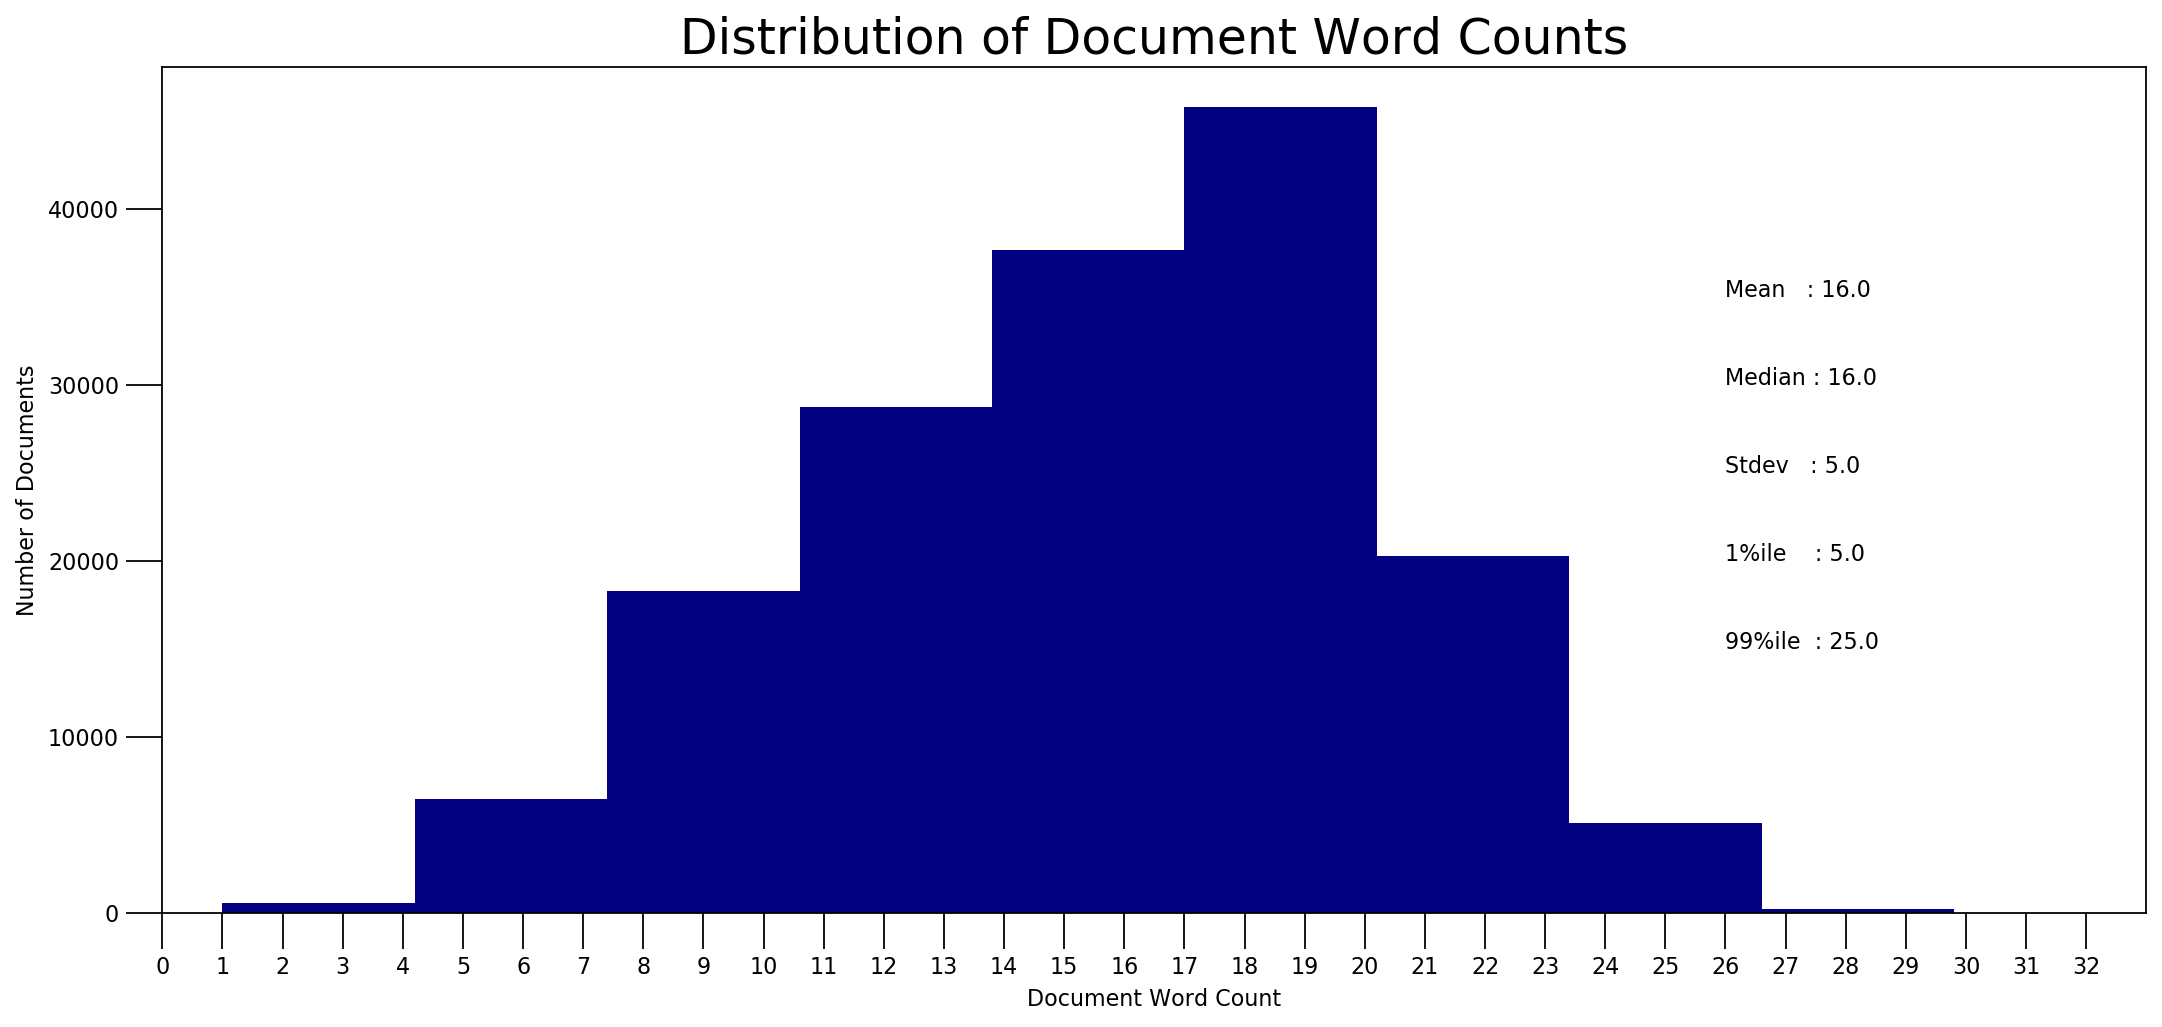

In [36]:
doc_lens = [len(d) for d in data_words]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, color='navy')
plt.text(26, 35000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(26, 30000, "Median : " + str(round(np.median(doc_lens))))
plt.text(26, 25000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(26, 20000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(26, 15000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, np.max(doc_lens)), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.arange(0,np.max(doc_lens)))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

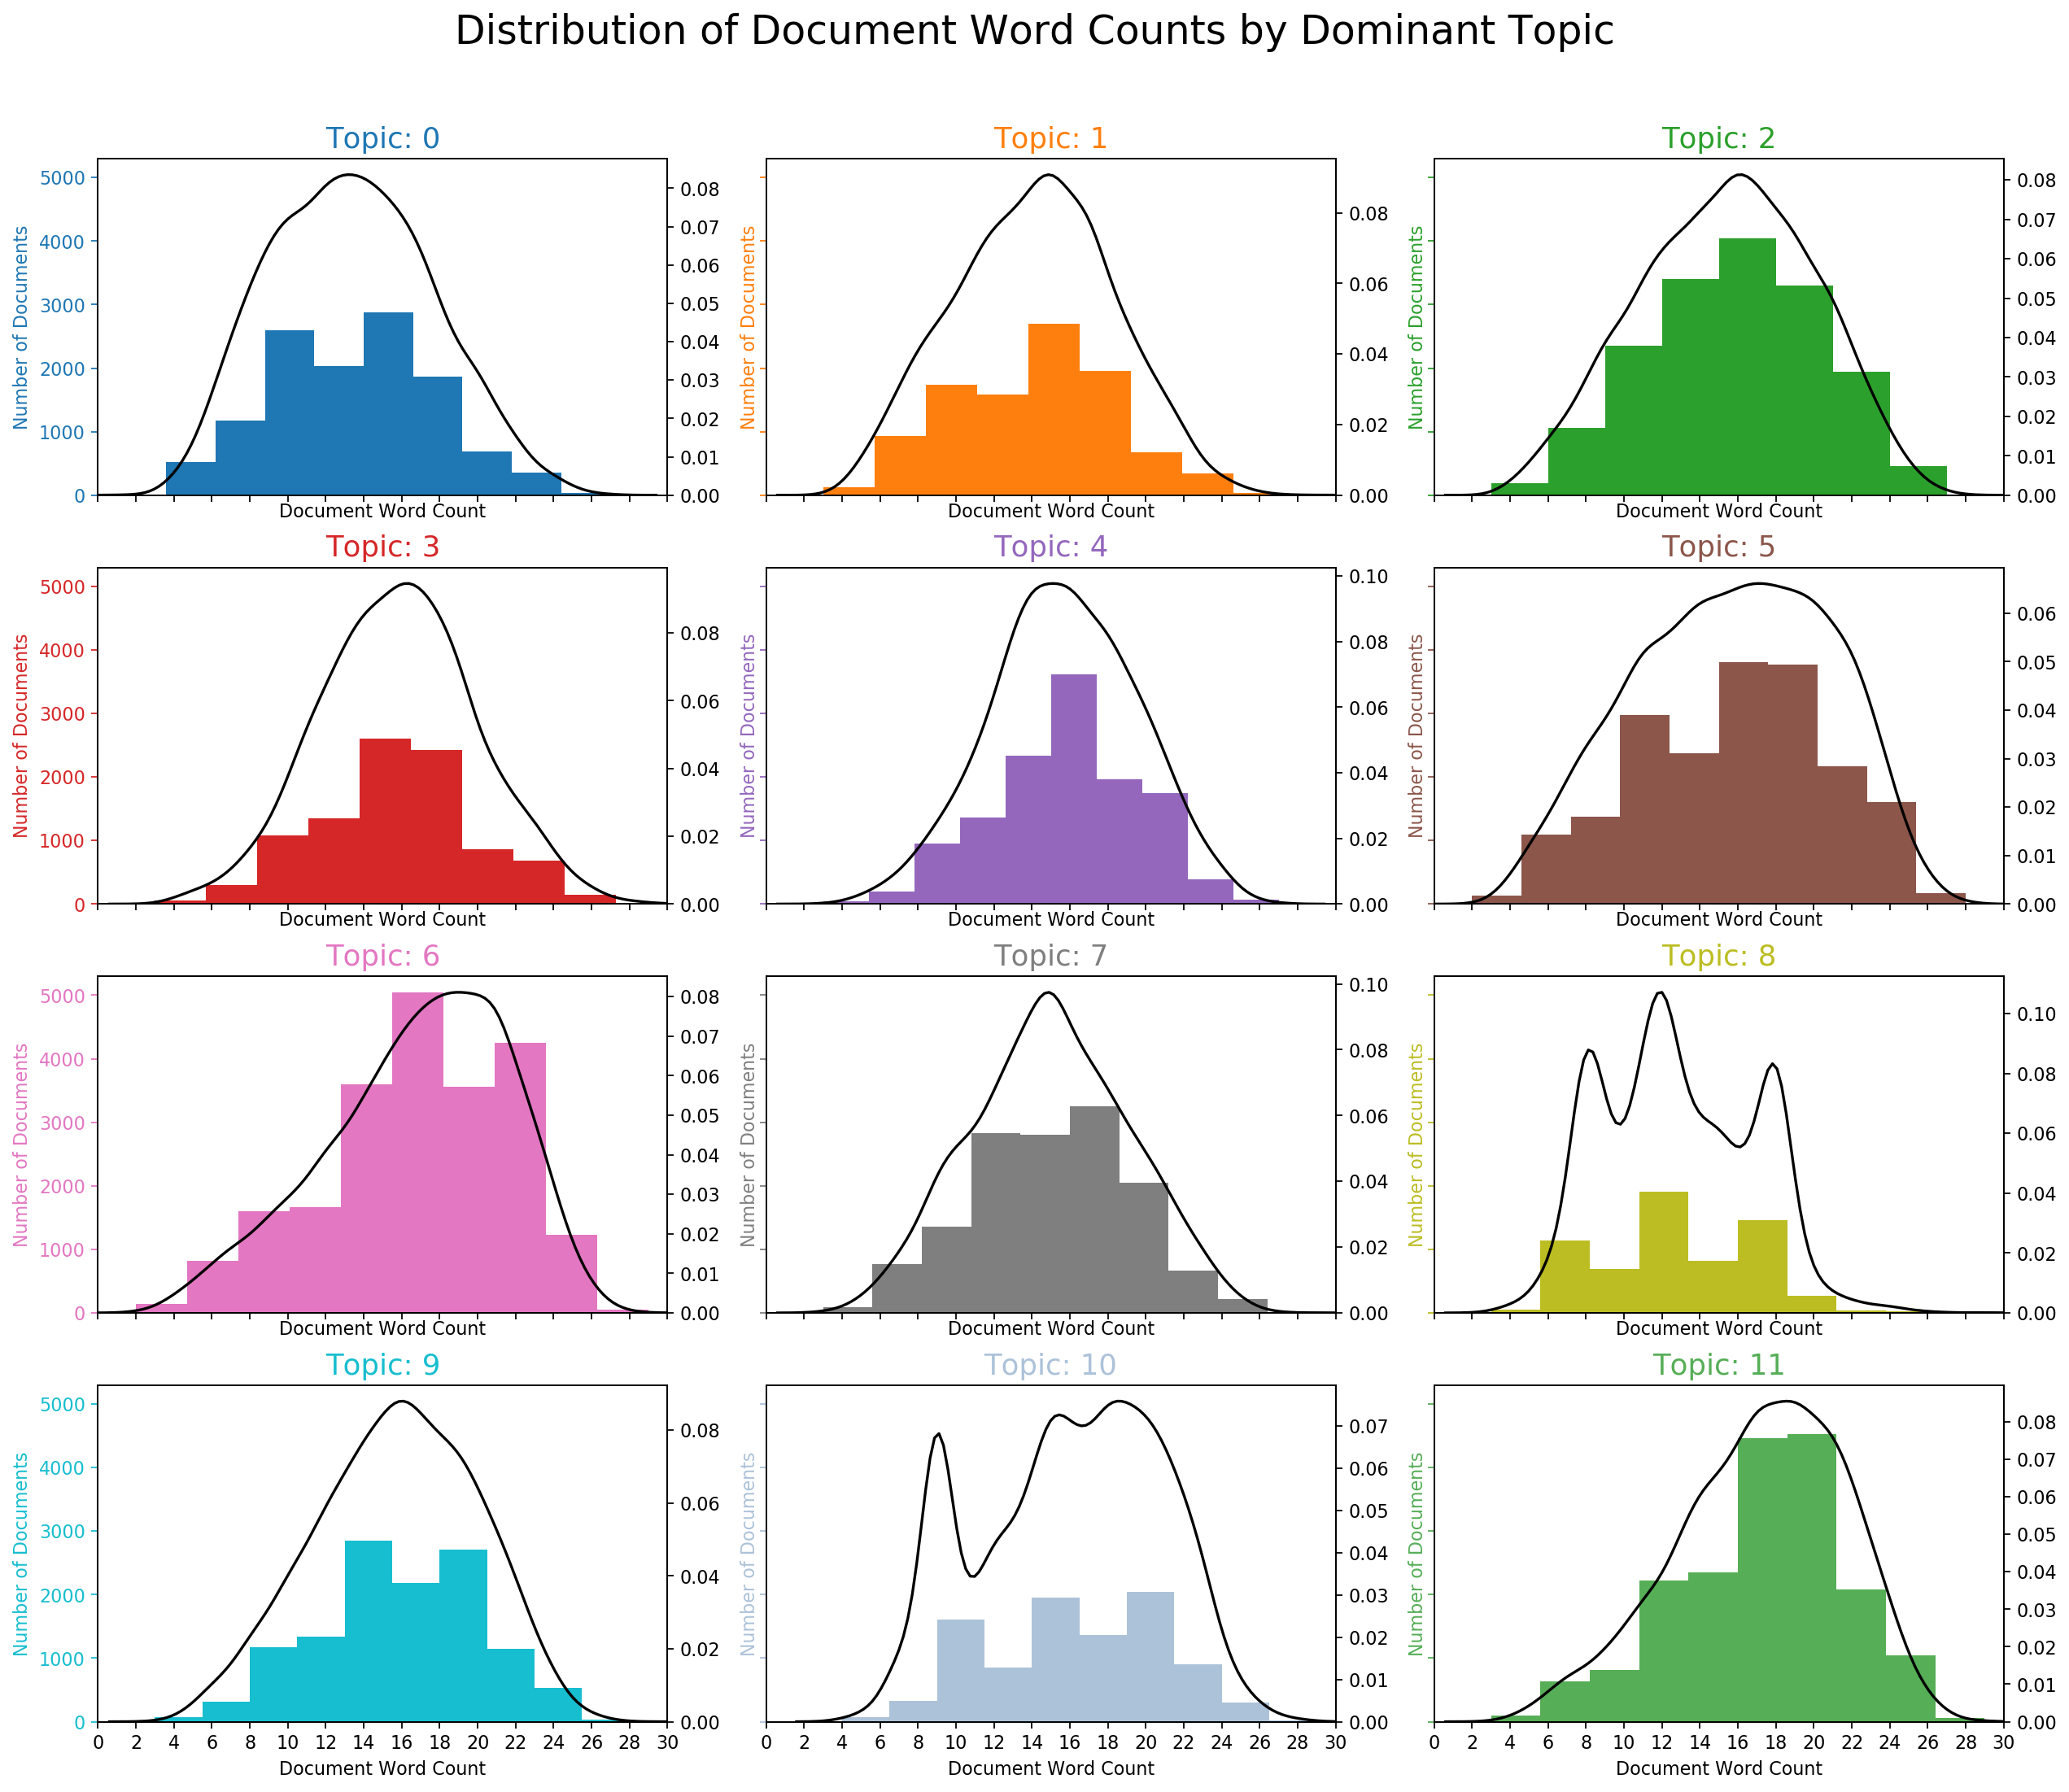

In [37]:
import seaborn as sns
import matplotlib.colors as mcolors
colors = mcolors.TABLEAU_COLORS
colors.update(mcolors.XKCD_COLORS)
cols = [color for name, color in colors.items()]  

fig, axes = plt.subplots(4,3,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Words]
    ax.hist(doc_lens, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, bw=0.8, ax=ax.twinx())
    ax.set(xlim=(0, 30), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.arange(0, 32, 2))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Cloud

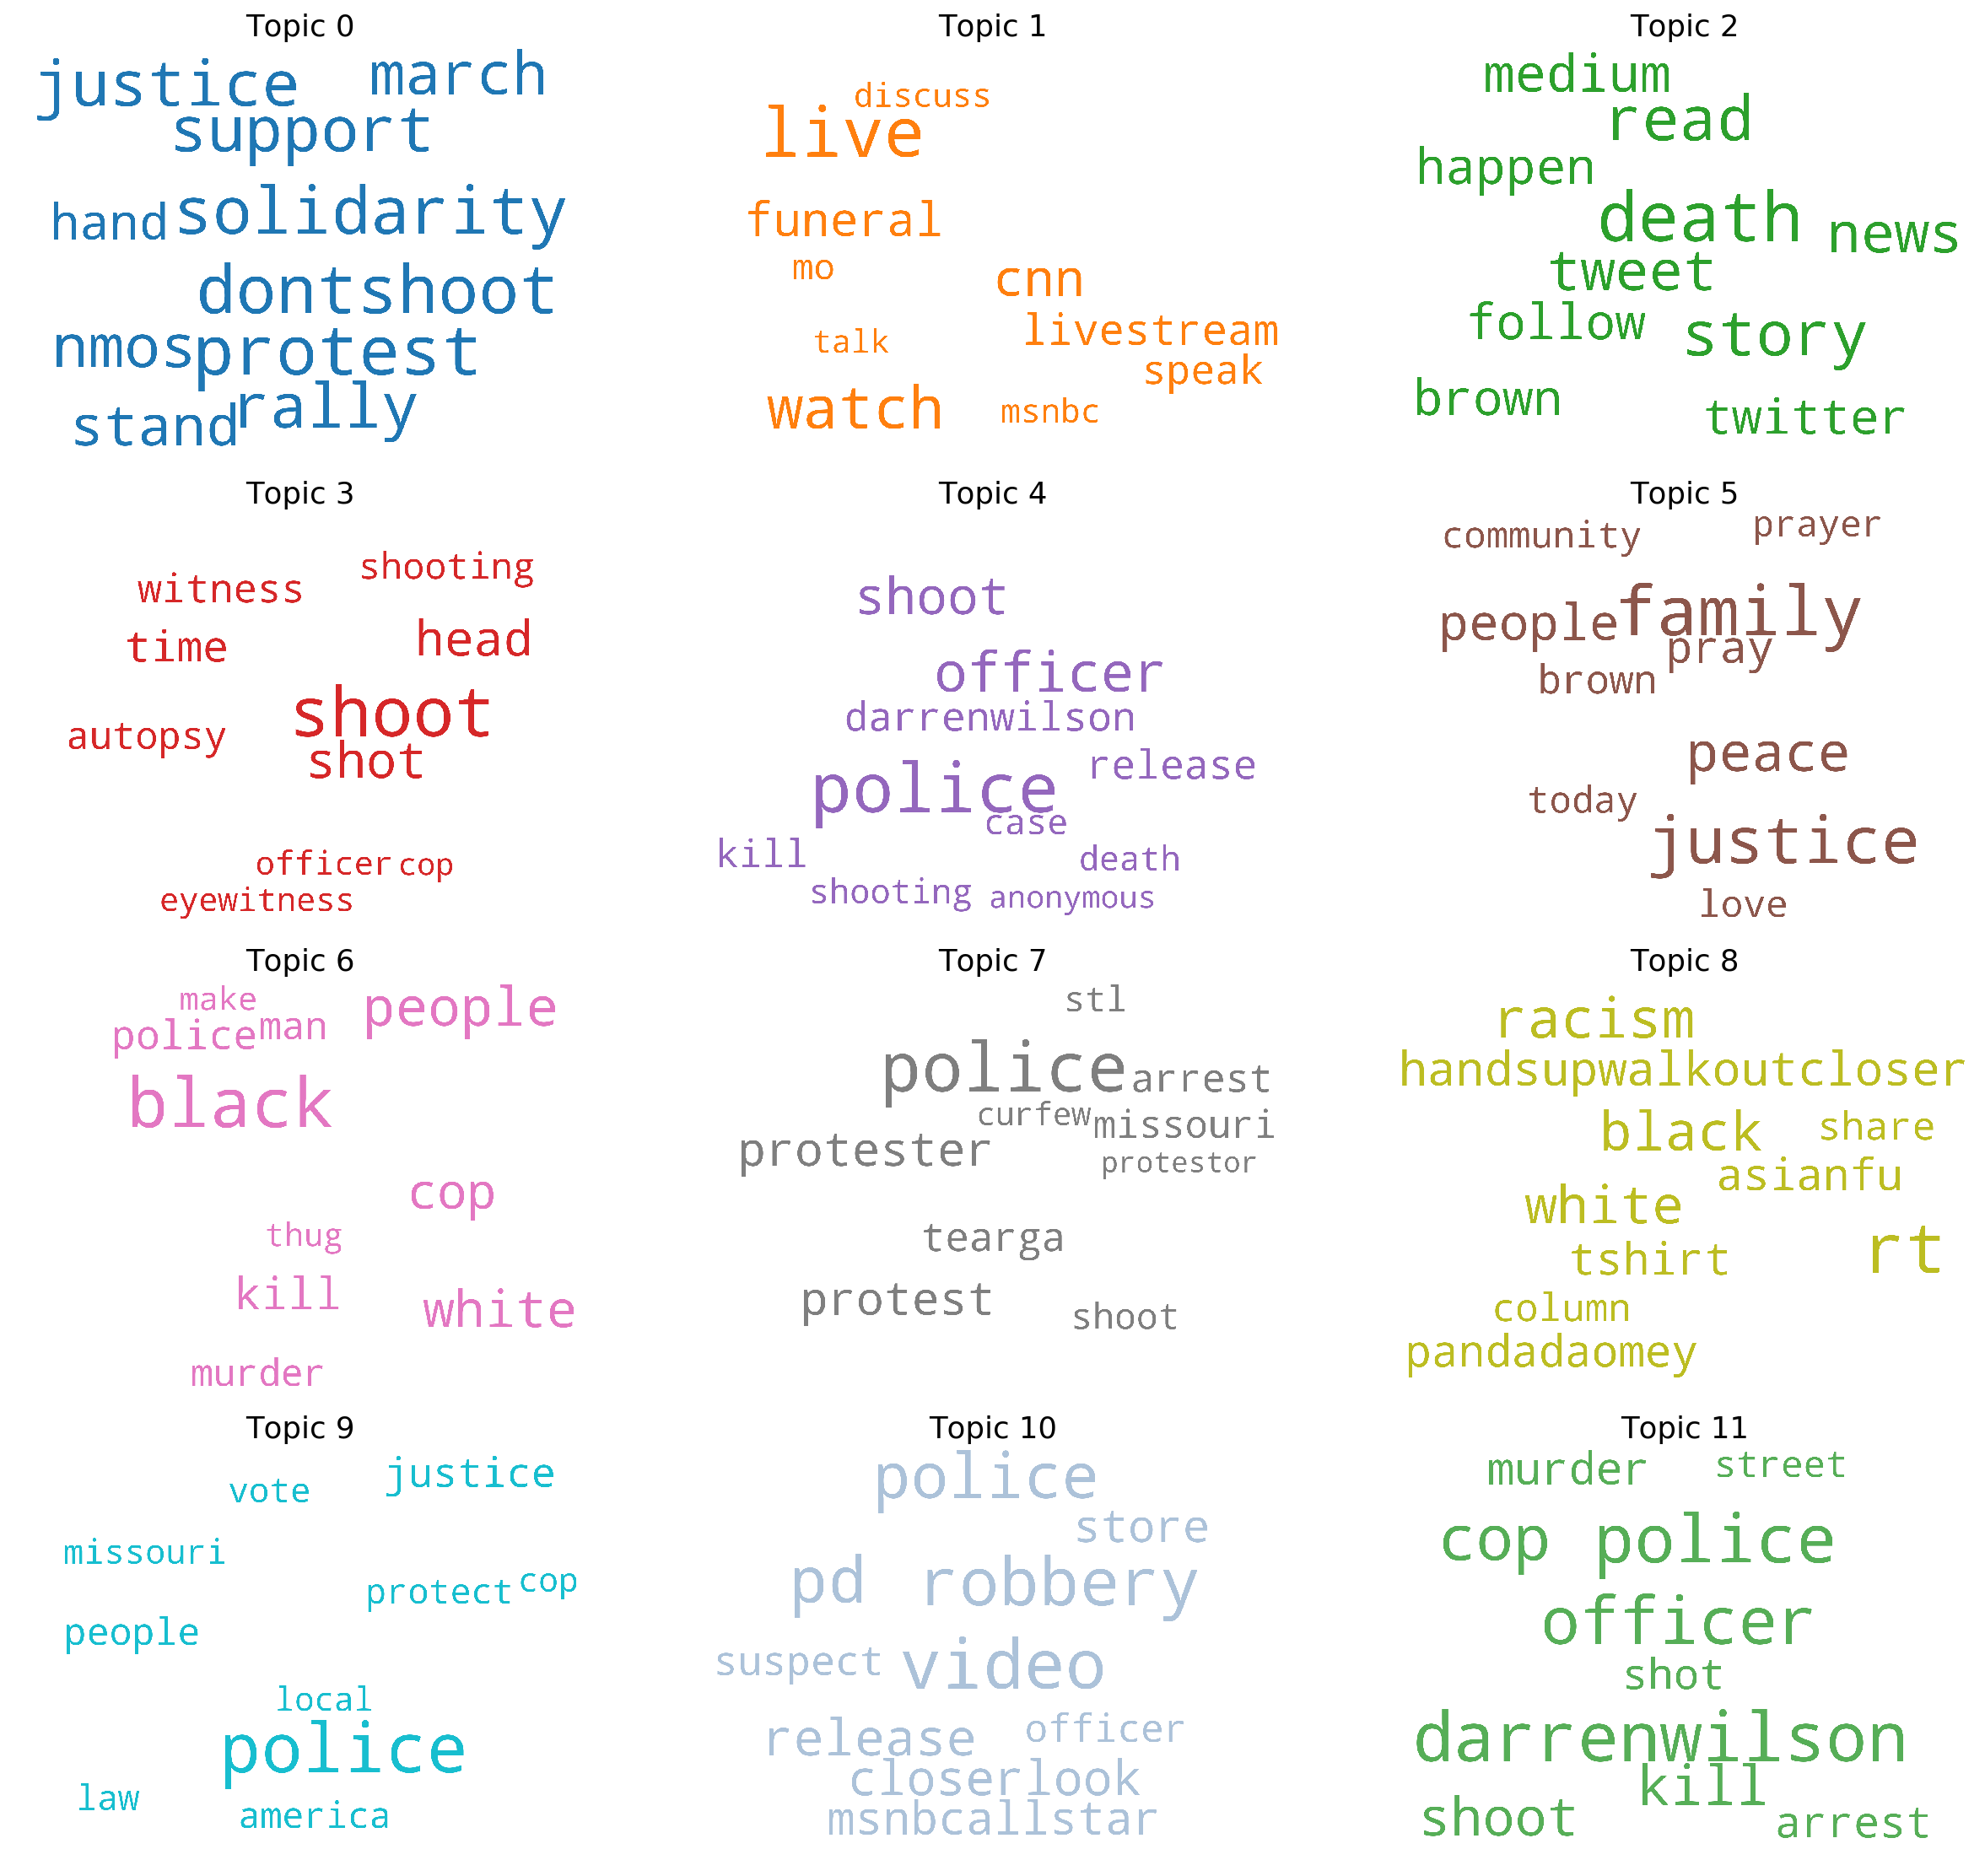

In [45]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

colors = mcolors.TABLEAU_COLORS
colors.update(mcolors.XKCD_COLORS)
cols = [color for name, color in colors.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=20)

fig, axes = plt.subplots(4, 3, figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word count of keywords

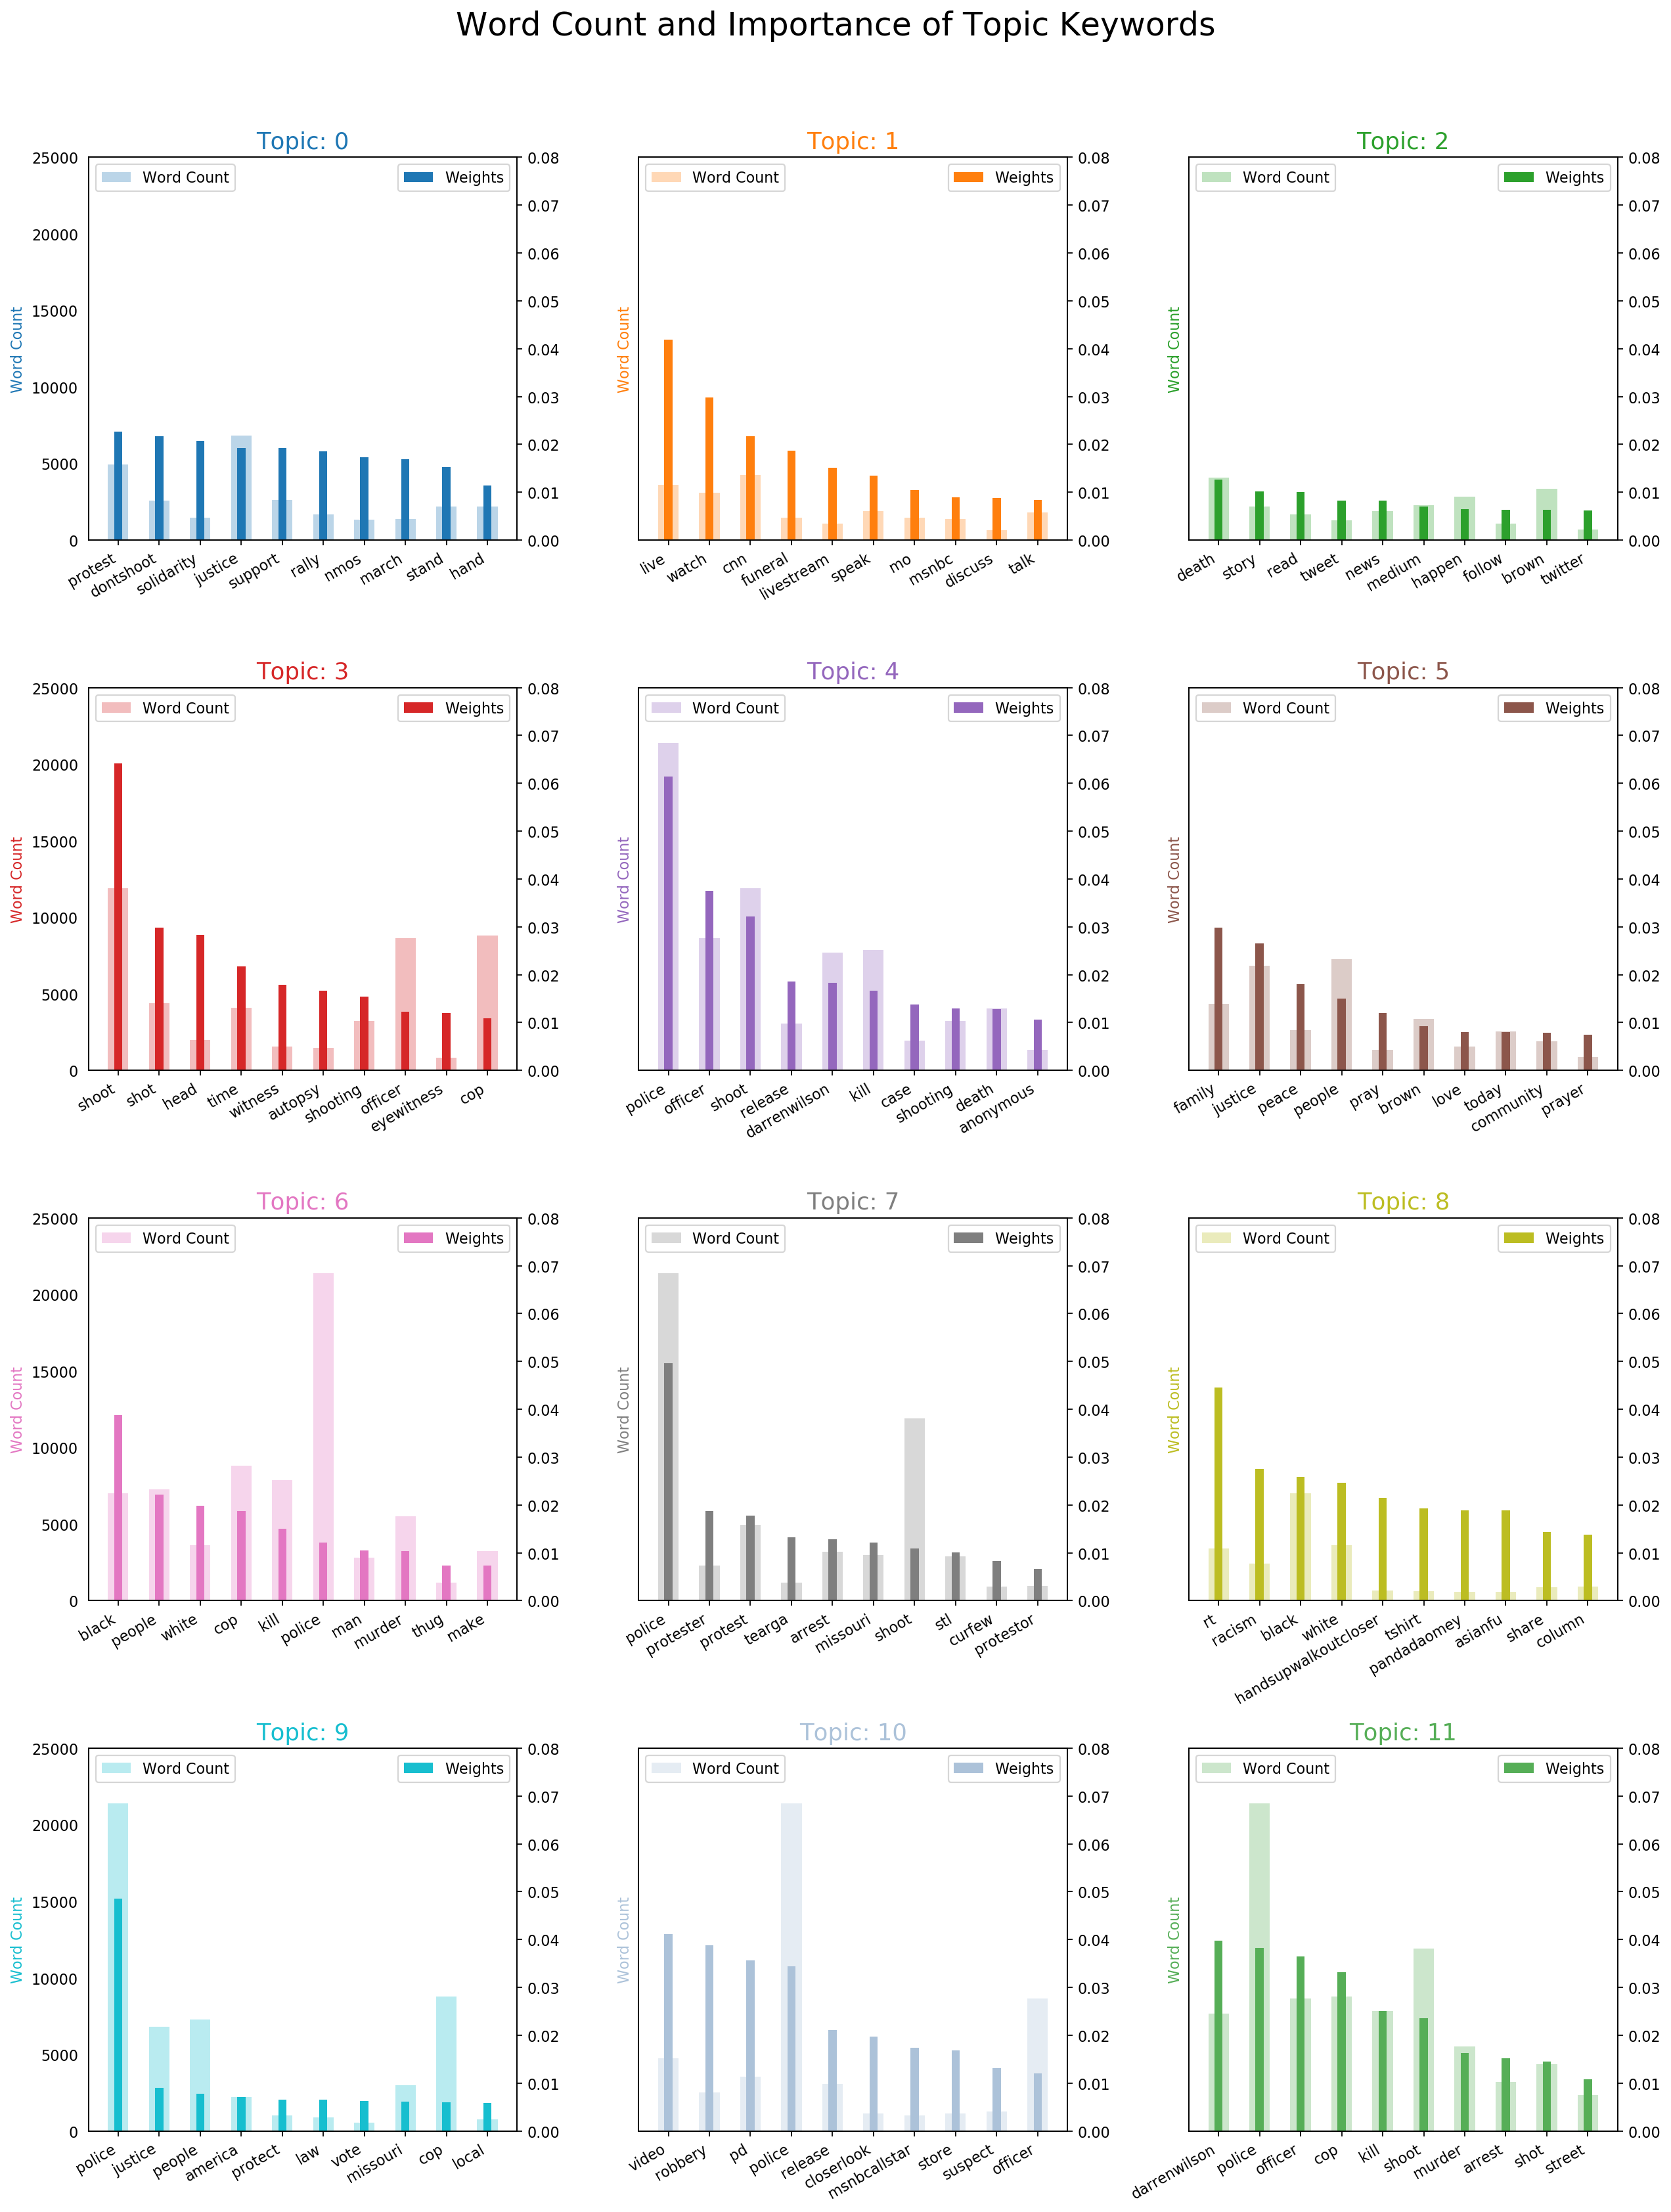

In [42]:
from collections import Counter
topics = optimal_model.show_topics(formatted=False, num_topics=20)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 3, figsize=(16,20), sharey=True, dpi=160)
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.08); ax.set_ylim(0, 25000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout()    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Sentence coloring

In [ ]:
# Sentence Coloring
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=optimal_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart() 

In [ ]:
help(optimal_model)

In [ ]:
optimal_model.id2word[0]

In [ ]:
optimal_model[corpus[4]]

In [ ]:
optimal_model[corpus[5]]

In [ ]:
optimal_model[corpus[6]]